# HCS Data Exploration

## Imports and Configurations

In [46]:
import sys  # Standard library imports

import matplotlib.pyplot as plt  # Related third party imports
import pandas as pd 
import numpy as np
import seaborn as sns
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

sys.path.append("../src")  # Local application/library specific imports
from scripts.utilities import convert_fractional_date

In [47]:
# Set Seaborn style and color palette
sns.set_style("darkgrid")
sns.set_palette("Pastel1")

In [48]:
# read the local csv file
hcs_df = pd.read_csv("../data/HCS/HCS_parameters_update_CR2257.csv")

# Data Wrangling

In [12]:
# gather datetime information from fractional dates provided
hcs_df['year'] = hcs_df['fyear_CS'].apply(lambda x: int(str(x).split('.')[0]))
hcs_df['date'] = hcs_df['fyear_CS'].apply(lambda x: convert_fractional_date(x))
hcs_df['date'].describe()

count                              616
mean     1999-05-27 16:05:23.106311552
min         1976-06-09 08:32:22.416001
25%      1987-12-03 03:52:12.755999744
50%      1999-05-27 22:07:55.704000512
75%      2010-11-19 06:30:30.276002048
max         2022-05-13 23:58:07.679999
Name: date, dtype: object

In [25]:
# apply log10 transformation

# log10 is undefined for values less than or equal to zero, so we need to check for these values
for col in ['SD_70', 'SL_70']:
    assert (hcs_df[f'{col}'] > 0).all(), f"Column {col} contains zero or negative values"

hcs_df['SD_70_log'] = np.log(hcs_df['SD_70'])
hcs_df['SL_70_log'] = np.log(hcs_df['SL_70'])

In [26]:
# Identify numerical columns
# Includes calculated fields (log10)
HCS_NUMERICAL_COLUMNS = hcs_df.select_dtypes(include=["int64", "float64"]).columns

# Exploration

In [27]:
# print information about the dataframe
print(f"Shape: {hcs_df.shape}")
hcs_df.info()

Shape: (616, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   cr_temp      616 non-null    int64  
 1   fyear_CS     616 non-null    float64
 2   sddv_CS      616 non-null    float64
 3   SD_70        616 non-null    float64
 4   SD_70_north  616 non-null    float64
 5   SD_70_south  616 non-null    float64
 6   slop_CS      616 non-null    float64
 7   SL_70        616 non-null    float64
 8   SL_70_north  616 non-null    float64
 9   SL_70_south  616 non-null    float64
 10  ave_slop_CS  616 non-null    float64
 11  HCS_length   616 non-null    object 
 12  HCS_area     596 non-null    float64
 13  SD_70_log    616 non-null    float64
 14  SL_70_log    616 non-null    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 72.3+ KB


`HCS_length` is object type because it has a few rows with non-float like values e.g., `368.90637228263.707031``. Should investigate what this means. 

In [28]:
# investigate missing values
print(hcs_df.isna().sum())
hcs_df_nona = hcs_df.dropna()
hcs_df[hcs_df['HCS_area'].isna()]

cr_temp         0
fyear_CS        0
sddv_CS         0
SD_70           0
SD_70_north     0
SD_70_south     0
slop_CS         0
SL_70           0
SL_70_north     0
SL_70_south     0
ave_slop_CS     0
HCS_length      0
HCS_area       20
SD_70_log       0
SL_70_log       0
dtype: int64


,cr_temp,fyear_CS,sddv_CS,SD_70,SD_70_north,SD_70_south,slop_CS,SL_70,SL_70_north,SL_70_south,ave_slop_CS,HCS_length,HCS_area,SD_70_log,SL_70_log
39,1681,1979.352173,23.050886,20.928221,21.072893,20.494844,802.773743,795.916016,494.458984,293.884552,4.865295,581.44183322943.103516,NaN,3.041099,6.679494
42,1684,1979.575806,25.508272,21.703094,20.373978,22.019829,374.015015,366.244934,248.588013,115.931877,3.495467,378.50064134801.347656,NaN,3.077455,5.903302
45,1687,1979.799805,23.296801,18.661228,18.451649,18.728991,579.040100,565.149475,478.089508,84.035324,4.825334,337.27917512519.793945,NaN,2.926448,6.337090
47,1689,1979.949341,21.316271,19.472345,18.849659,20.037155,1107.385254,1105.544678,403.287292,668.846436,5.890347,601.32934635480.246094,NaN,2.968995,7.008093
69,1711,1981.590698,17.143057,17.143057,18.936176,14.962254,310.206909,310.206909,172.119019,131.289795,1.762539,438.34710729124.953125,NaN,2.841593,5.737240
78,1720,1982.263794,15.647516,15.647516,15.864513,15.294233,183.148773,183.148773,33.783222,140.522476,1.465190,252.35899413350.006836,NaN,2.750312,5.210299
167,1809,1988.908691,13.895020,13.895020,14.492928,12.591744,256.423492,256.423492,184.987076,65.751709,1.633271,369.12863220487.210938,NaN,2.631531,5.546830
171,1813,1989.207886,20.237234,19.577274,18.917437,20.027634,629.308350,624.204346,436.294983,180.893311,3.680166,576.50262522425.298828,NaN,2.974369,6.436478
179,1821,1989.804932,22.526665,19.524065,20.234205,18.682356,242.988113,240.052032,169.158707,60.733307,1.869139,495.49102848206.304688,NaN,2.971648,5.480856
314,1956,1999.887573,23.693529,20.988781,21.540363,19.613396,731.045105,724.291016,506.845947,204.880524,4.038923,628.26770027367.851563,NaN,3.043988,6.585193


`HCS_area` has 20 missing values which we should ask about. What do missing values indicate? Should we do imputation? 

In [29]:
# proportion of dataset that contains unique values
(hcs_df.nunique()/len(hcs_df)*100).sort_values(ascending=False)

cr_temp        100.000000
fyear_CS       100.000000
sddv_CS         99.837662
SD_70           99.837662
SD_70_north     99.837662
SD_70_south     99.837662
slop_CS         99.837662
SL_70           99.837662
SL_70_north     99.837662
SL_70_south     99.837662
ave_slop_CS     99.837662
HCS_length      99.837662
SD_70_log       99.837662
SL_70_log       99.837662
HCS_area        96.590909
dtype: float64

In [30]:
hcs_df.describe().drop(columns=['fyear_CS']) # drop the fractional year column

,cr_temp,sddv_CS,SD_70,SD_70_north,SD_70_south,slop_CS,SL_70,SL_70_north,SL_70_south,ave_slop_CS,HCS_area,SD_70_log,SL_70_log
count,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,596.000000,616.000000,616.000000
mean,1949.500000,13.443172,13.069014,12.443054,12.942022,395.372919,389.992815,211.950206,150.744176,2.691969,886.252966,2.451482,5.046144
std,177.968162,6.086021,5.587241,6.114018,5.831173,724.404814,716.791825,493.842421,314.712774,4.431123,1326.617525,0.527950,1.391719
min,1642.000000,1.841347,1.841347,1.345982,1.344595,7.089793,7.089793,2.758448,2.867834,0.089744,148.888626,0.610497,1.958656
25%,1795.750000,8.206198,8.206198,7.056436,8.257072,47.375711,47.375711,20.285056,23.901317,0.457463,448.658364,2.104887,3.858084
50%,1949.500000,12.976606,12.976606,12.241110,12.911891,161.837066,161.837066,67.132710,65.584690,1.245355,584.331970,2.563148,5.086577
75%,2103.250000,18.792511,18.379632,18.155626,18.049276,456.660309,454.493645,201.065273,170.992901,3.176744,719.399856,2.911243,6.119183
max,2257.000000,25.508272,22.579355,25.071970,24.830502,8278.967773,8274.589844,7159.270508,5260.224121,44.751179,9568.851563,3.117036,9.020945


## Univariate Analysis


### Kernel Density Plots

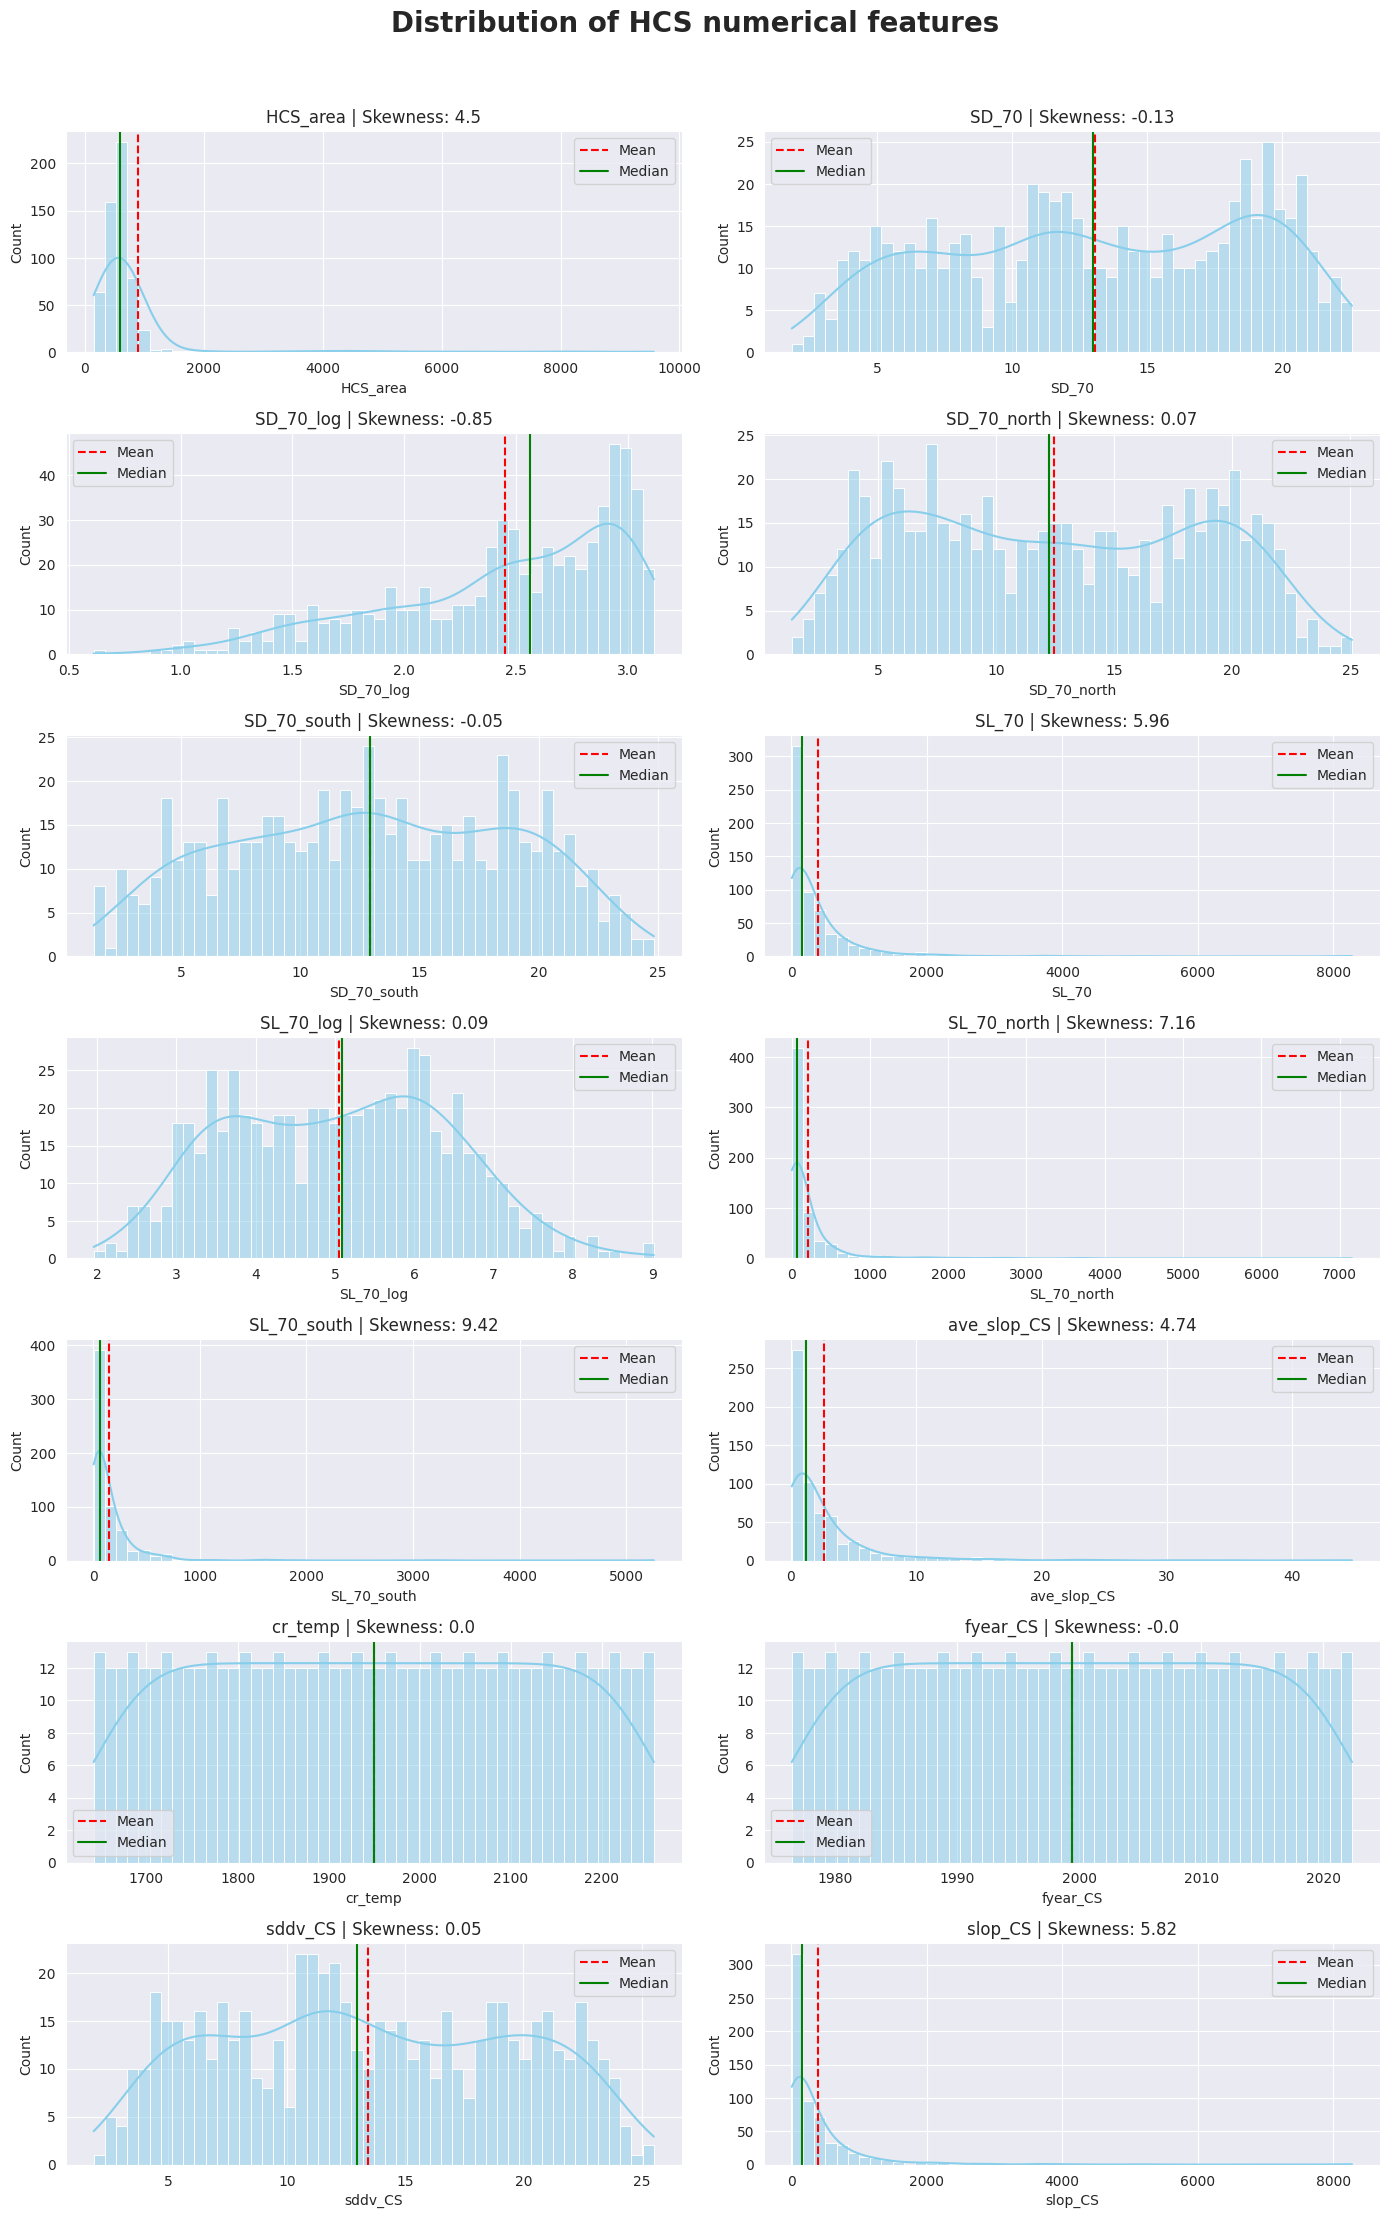

In [45]:


# Plot distribution of each numerical feature
fig = plt.figure(figsize=(14, len(HCS_NUMERICAL_COLUMNS) * 3))
for idx, feature in enumerate(np.sort(HCS_NUMERICAL_COLUMNS), 1):
    plt.subplot(len(HCS_NUMERICAL_COLUMNS), 2, idx)
    sns.histplot(hcs_df[feature], kde=True, bins=50, color="skyblue")
    
    # Add lines for mean and median
    plt.axvline(hcs_df[feature].mean(), color='r', linestyle='--',label='Mean')
    plt.axvline(hcs_df[feature].median(), color='g', linestyle='-',label='Median')
    
    plt.title(f"{feature} | Skewness: {round(hcs_df[feature].skew(), 2)}")
    plt.legend()  # Add a legend
 
# Adjust layout and show plots
plt.tight_layout()
fig.suptitle("Distribution of HCS numerical features", fontsize=20, weight='bold', y=1.02)
plt.show()



## Bivariate analysis

In [50]:
plt.figure(figsize=(10, 6))
 
# Using Seaborn to create a pair plot with the specified color palette
sns.pairplot(hcs_df[HCS_NUMERICAL_COLUMNS],corner=True, diag_kind='kde')
 
plt.title('Pair Plot for DataFrame')
plt.show();

KeyError: "['SD_70_log', 'SL_70_log'] not in index"

<Figure size 1000x600 with 0 Axes>

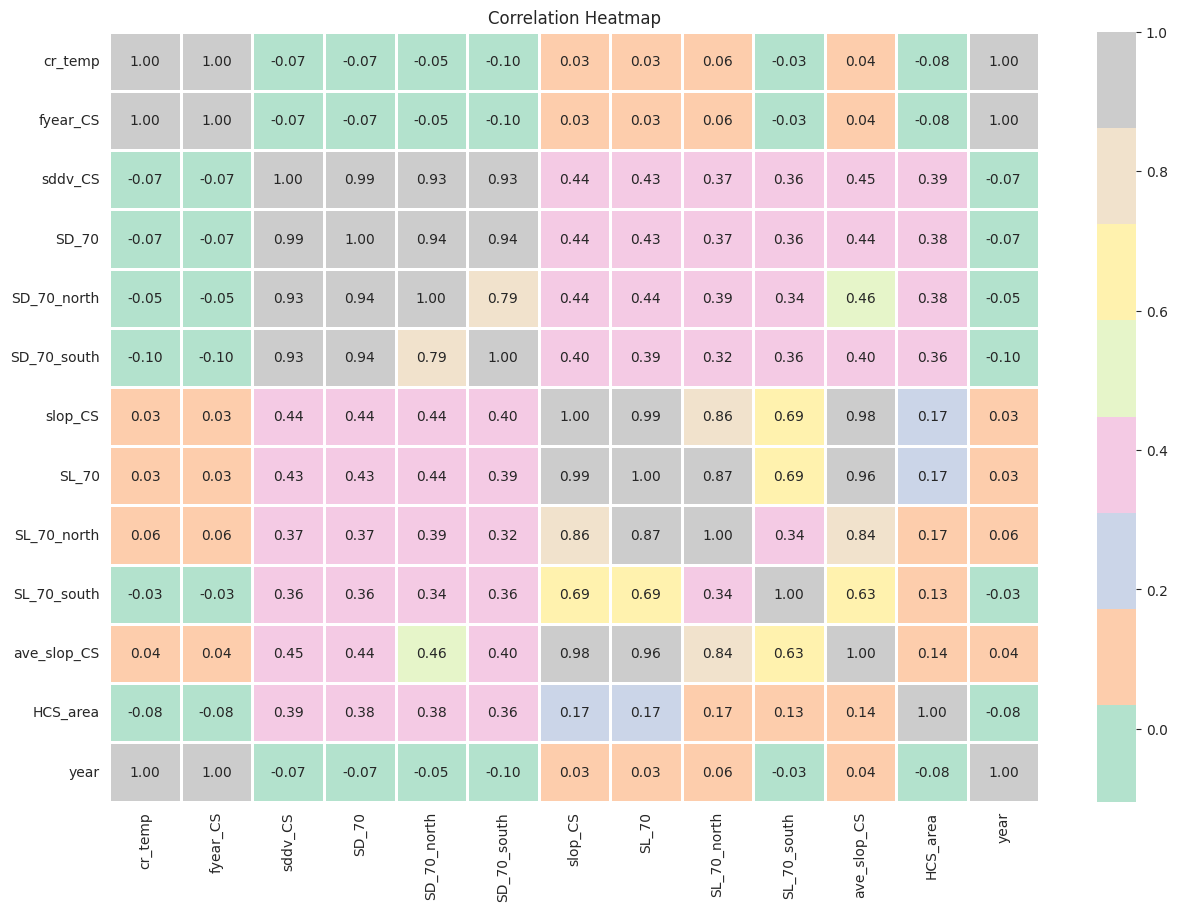

In [12]:
# Assuming 'df' is your DataFrame
plt.figure(figsize=(15, 10))
 
# Using Seaborn to create a heatmap
sns.heatmap(hcs_df[HCS_NUMERICAL_COLUMNS].corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)
 
plt.title('Correlation Heatmap')
plt.show()

## Multivariate Analysis

In [ ]:
# Assuming 'df' is your DataFrame
plt.figure(figsize=(15, 10))
 
# Using Seaborn to create a heatmap
sns.heatmap(hcs_df[HCS_NUMERICAL_COLUMNS].corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)
 
plt.title('Correlation Heatmap')
plt.show()

### Exploratory Factor Analysis

A factor is a latent variable which describes the association among the number of observed variables.

Assumptions:

- There are no outliers in data.
- Sample size should be greater than the factor.
- There should not be perfect multicollinearity.
- There should not be homoscedasticity between the variables.

Resources: 
- https://www.datacamp.com/tutorial/introduction-factor-analysis

In [18]:
chi_square_value,p_value=calculate_bartlett_sphericity(hcs_df_nona[HCS_NUMERICAL_COLUMNS])
chi_square_value, p_value

(28249.15904668624, 0.0)

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis. In this Bartlett ’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

In [22]:
kmo_all,kmo_model=calculate_kmo(hcs_df_nona[HCS_NUMERICAL_COLUMNS])
kmo_model

0.7730835379862939

Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [31]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation=None)
fa.fit(hcs_df_nona[HCS_NUMERICAL_COLUMNS])

# Check Eigenvalues
ev, v = fa.get_eigenvalues()

array([5.92319956e+00, 3.10860616e+00, 2.12903570e+00, 8.12196536e-01,
       6.68841141e-01, 2.13680800e-01, 9.34328015e-02, 2.18574669e-02,
       1.68943339e-02, 6.59277559e-03, 5.35206376e-03, 3.10669531e-04,
       9.21194397e-10])

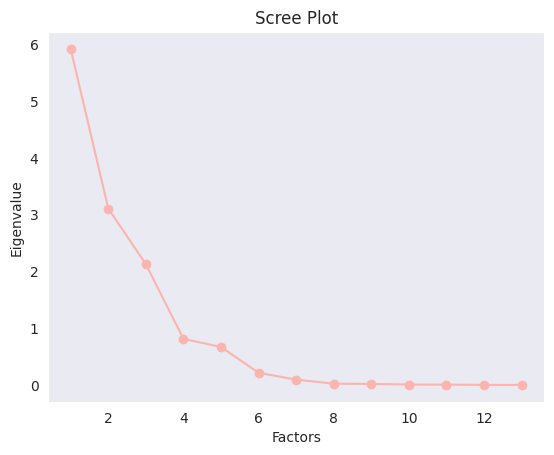

In [34]:
# Create scree plot using matplotlib
plt.scatter(range(1,hcs_df_nona[HCS_NUMERICAL_COLUMNS].shape[1]+1),ev)
plt.plot(range(1,hcs_df_nona[HCS_NUMERICAL_COLUMNS].shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [42]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation="varimax")
fa.fit(hcs_df_nona[HCS_NUMERICAL_COLUMNS], 5)
fa.loadings_

array([[ 0.02413417, -0.06036158,  0.99699326],
       [ 0.02413821, -0.0603545 ,  0.9969938 ],
       [ 0.23823549,  0.97445034, -0.02618907],
       [ 0.23290359,  0.97746986, -0.0241562 ],
       [ 0.26167504,  0.87536949, -0.00562895],
       [ 0.21717514,  0.88151925, -0.06455014],
       [ 0.98465789,  0.21543575,  0.0217186 ],
       [ 0.98440255,  0.21097761,  0.02181873],
       [ 0.80282685,  0.18188991,  0.05165487],
       [ 0.58695381,  0.23501822, -0.02728841],
       [ 0.95600459,  0.22816376,  0.03054642],
       [ 0.08985755,  0.37976429, -0.0577828 ],
       [ 0.02396162, -0.05928811,  0.99698661]])

In [43]:
fa.get_factor_variance()

(array([4.07804281, 3.83467121, 2.99607485]),
 array([0.3136956 , 0.29497471, 0.2304673 ]),
 array([0.3136956 , 0.60867031, 0.8391376 ]))

### PCA


In [52]:
X = hcs_df[HCS_NUMERICAL_COLUMNS]
features = X.columns

# impute missing values using KNN Imputer
imputer = KNNImputer(n_neighbors=5)  # Use 5 nearest neighbors
X_imputed = imputer.fit_transform(X)

# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Perform PCA
pca = PCA(n_components=10)  # We reduce to 5 components
X_pca = pca.fit_transform(X_scaled)

KeyError: "['SD_70_log', 'SL_70_log'] not in index"

In [53]:
print("Explained variance",pca.explained_variance_)
print("Explained variance ratios",pca.explained_variance_ratio_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.show()

NameError: name 'pca' is not defined

This plot shows the cumulative explained variance as you add more components. The 'elbow' in the plot can be a good choice for the number of components to keep and currently it bows at around 5 components. 

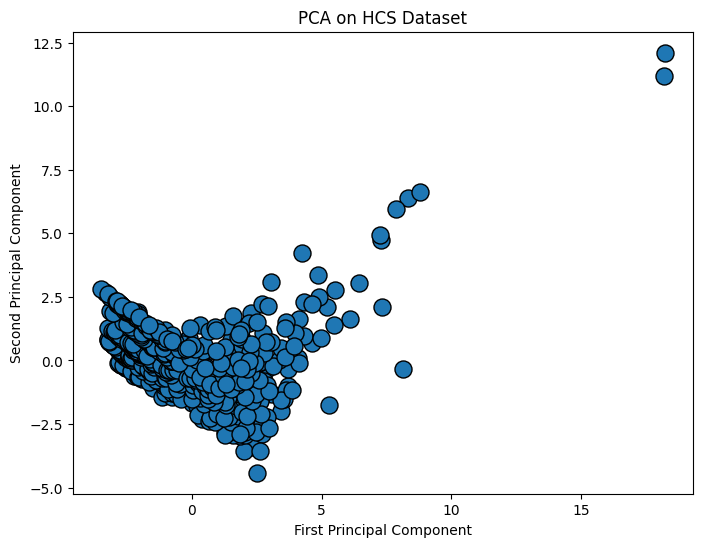

In [28]:
# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='k', s=150)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA on HCS Dataset')
plt.show()

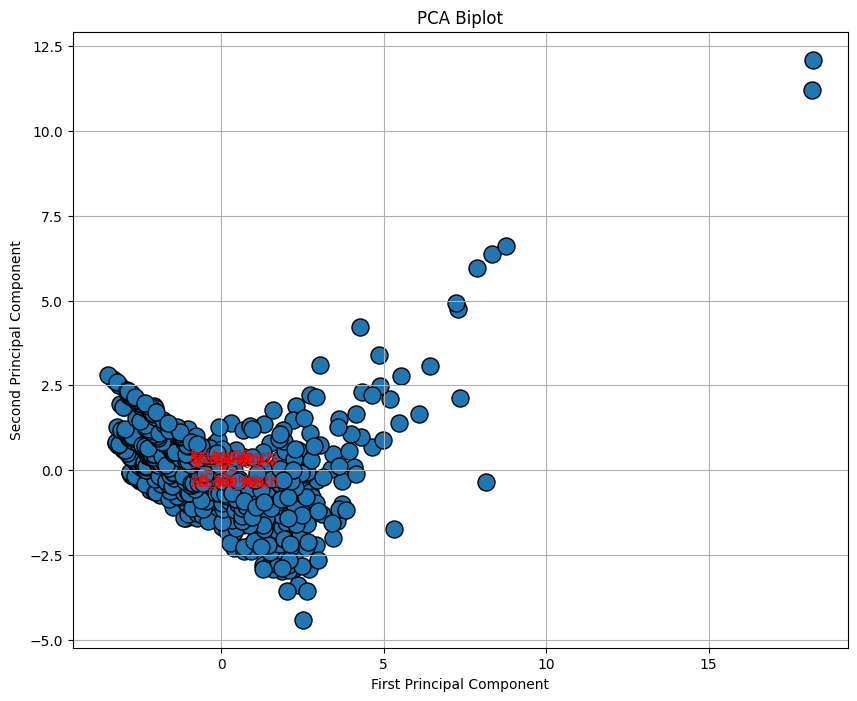

In [32]:
# Create a figure
plt.figure(figsize=(10, 8))

# Plot the projected data
plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='k', s=150)

# Plot the component loadings
for i, feature in enumerate(features):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='r', alpha=0.5)
    plt.text(pca.components_[0, i]*1.2, pca.components_[1, i]*1.2, feature, color='r', ha='center', va='center')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Biplot')
plt.grid(True)
plt.show()